# HOMEWORK 3: Designing Closed Loop Systems

**COMMENTS**

7.5/10. You generally got the correct answers, but you failed to have tests for evaluateDesign and your answers to Q3 did not make reference to transfer functions (as requested by the question). Also, you got an extra point for turning in the homework by the original deadline.

This homework involves designing a closed loop system with a PID controller.

In [ ]:
!pip -q install controlSBML
import controlSBML as ctl
import control
from controlSBML.util import makeSimulationTimes
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sympy as sy
import tellurium as te
import sympy
print("controlSBML version: " + ctl.__version__)

     |████████████████████████████████| 398 kB 6.8 MB/s 
     |████████████████████████████████| 8.8 MB 39.6 MB/s 
     |████████████████████████████████| 154 kB 38.4 MB/s 
     |████████████████████████████████| 438 kB 47.5 MB/s 
     |████████████████████████████████| 6.8 MB 14.1 MB/s 
     |████████████████████████████████| 121 kB 42.0 MB/s 
     |████████████████████████████████| 428 kB 44.1 MB/s 
     |████████████████████████████████| 54 kB 798 kB/s 
     |████████████████████████████████| 342 kB 59.8 MB/s 
     |████████████████████████████████| 561 kB 58.7 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 130 kB 61.2 MB/s 
     |████████████████████████████████| 80 kB 8.9 MB/s 
     |████████████████████████████████| 133 kB 58.6 MB/s 
     |████████████████████████████████| 103 kB 56.5 MB/s 
     |████████████████████████████████| 250 kB 50.5 MB/s 
     |████████████████████████████████| 843 kB 58.3 MB/s 
     |███████████████

In [ ]:
# Use the local file if it's available
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

In this homework, you will design a closed loop system for controlling pDEPTOR in the mTOR system as modelled in BioModels 823.
Use pAkt as the control input.
1. **Build**. (4 pt) Implement the function ``evaluateDesign`` that evaluates the control design of
a closed loop system for mTOR.
The evaluation is in the form of a plot of the step response of the system
to a change in the reference input.
The plot should include the reference input along with the pAkt and pDEPTO
values for the closed loop mTOR system. The function has as inputs the design parameters kp, ki, kd.
1. **Design**. (2 pt) Use ``evaluateDesign`` to design a system that has no bias for a unit step response in the reference and settles within 10 seconds.
1. **Analysis**. (3 pt) Construct the transfer function
for mTOR from pAkt to pDEPTOR
and the transfer function $H_{NY} (s)$ for the design parameters you used in (2)
(Obtain the Jacobian at time 1 from the open loop mTOR system.)
Use these transfer functions to answer the following questions about how the closed loop system should behave *in theory*.
   1. Why are large control inputs required to control the mTOR system?
   1. Why are there no long term oscillations in the closed loop system?
   1. How will a step increase in noise affect the output of the closed loop system?
1. **Discussion**. (1 pt) Plot the values of pAkt for the closed loop system you designed in (2).
What issues do you see with using this closed loop system in practice?

# Q1. Build

**Building the Antimony Model (NOT NECESSARY, just a good visual of system dynamics)**

All results for initial conditions and reactions can be found in the supplemental

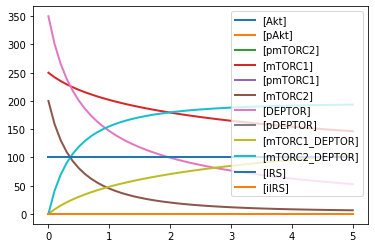

In [ ]:
mTOR_MODEL = """
# J1: IR -> pIR; (V1*IR)/(Km1+IR)
# J2: pIR -> IR; (V2*pIR)/(Km2+pIR)
# J3: IRS -> pIRS; (k3c*pIR*IRS)/(Km3+IRS)
# J4: pIRS -> IRS; (V4*pIRS)/(Km4+pIRS)
J5: Akt -> pAkt; (k5ca*pIRS*Akt)/(Km5a+Akt) + (k5cb*pmTORC2*Akt)/(Km5b+Akt)
J6: pAkt -> Akt; (V6*pAkt)/(Km6+pAkt)
J7: mTORC1 -> pmTORC1; (k7c*pAkt*mTORC1)/(Km7+mTORC1)
J8: pmTORC1 -> mTORC1; (V8*pmTORC1)/(Km8+pmTORC1)
J9: mTORC2 -> pmTORC2; (k9c*pIR*mTORC2)/(Km9+mTORC2)
J10: pmTORC2 -> mTORC2; (V10*pmTORC2)/(Km10+pmTORC2)
J11: DEPTOR -> pDEPTOR; (k11ca*pmTORC1*DEPTOR)/(Km11a+pDEPTOR) + (k11cb*pmTORC2*DEPTOR)/(Km11b+DEPTOR)
J12: pDEPTOR -> DEPTOR; (V12*pDEPTOR)/(Km12+pDEPTOR)
J13: mTORC1 + DEPTOR -> mTORC1_DEPTOR; k13f*mTORC1*DEPTOR
J14: mTORC1_DEPTOR -> mTORC1 + DEPTOR; k13r*mTORC1_DEPTOR
J15: mTORC2 + DEPTOR -> mTORC2_DEPTOR; k14f*mTORC2*DEPTOR
J16: mTORC2_DEPTOR -> mTORC2 + DEPTOR; k14r*mTORC2_DEPTOR
J17: IRS -> iIRS; (k15c*pmTORC1*IRS)/(Km15+IRS)
J18: iIRS -> IRS; (V16*iIRS)/(Km16+iIRS) 
J19: -> DEPTOR; ks17
J20: pDEPTOR -> ; kd18*pDEPTOR

V1 = 1
Km1 = 95
V2 = 1
Km2 = 35
k3c = 0.1
Km3 = 50
V4 = 1
Km4 = 50
k5ca = 0.05
Km5a = 7
k5cb = 1.5
Km5b = 4
V6 = 2
Km6 = 34
k7c = 0.1
Km7 = 2
V8 = 6
Km8 = 1
k9c = 0.3
Km9 = 160
V10 = 3
Km10 = 7
k11ca = 0.1
Km11a = 120
k11cb = 0.13
Km11b = 11
V12 = 4
Km12 = 7
k13f = 0.001
k13r = 0.006
k14f = 0.007
k14r = 0.006
k15c = 0.1
Km15 = 50
V16 = 1
Km16 = 50
ks17 = 0.0001
kd18 = 0.00003

IR = 50
pIR = 0
IRS = 100
pIRS = 0
iIRS = 0
Akt = 100
pAkt = 0
mTORC1 = 250
pmTORC1 = 0
mTORC2 = 200
pmTORC2 = 0
imTORC2 = 0
mTORC1_DEPTOR = 0
mTORC2_DEPTOR = 0
DEPTOR = 350
pDEPTOR = 0

"""
mTOR_MODEL_RR = te.loada(mTOR_MODEL)
mTOR_MODEL_DATA = mTOR_MODEL_RR.simulate()
mTOR_MODEL_RR.plot(mTOR_MODEL_DATA)

**Building the evaluateDesign Function**

**COMMENTS**

You should have the function documentation INSIDE the function so that it can be displayed automatically by development environments like Jupyter.

You didn't have tests for evaluateDesign. This is serious because you (or someone who uses your code) won't detect errors as changes are made to the notebook. I took off 2 points.

In [ ]:
"""
---Acceptable inputs: kp, ki, and kd values are floats---
---evaluateDesign function plots the reference input, pAkt, and pDEPTOR and returns all of these values. Additionally it calculates the absolute difference between the setpoint (3) and the output at time = 10s---
---The absolute differences helps to evaluate which kp, ki, and kd values will help design a system without bias and that will settle within 10 seconds---
"""

def evaluateDesign(k_p, k_i, k_d):
  # ctlsb = ctl.ControlSBML(mTOR_MODEL, input_names=['pAkt'], output_names=['pDEPTOR'])  --> alternative way to achieve output using the tellurium model built above

  # Initiating the control package and building the IO system elements
  ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml", input_names=['pAkt'], output_names=['pDEPTOR'])
  FACTORY = ctl.IOSystemFactory()
  controller = FACTORY.makePIDController("controller", kp=k_p, ki=k_i, kd=k_d)
  system = ctlsb.makeNonlinearIOSystem("system")
  sum_R_S = FACTORY.makeAdder("sum_R_S")
  
  # Defining connections in the closed loop feedback system
  closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in','sum_R_S.out'],
    ['system.pAkt', 'controller.out'],
    ['sum_R_S.in1', "-" + "system.pDEPTOR"]
   ],
  inplist=["sum_R_S.in2"],
  outlist = ["sum_R_S.in2", 'system.pAkt', "system.pDEPTOR"]
  )

  # Simulating the step response
  X0 = ctl.makeStateVector(closed_loop)  # obtaining initial values (also available in the supplement of the paper)
  times = ctl.makeSimulationTimes(start_time=0, end_time=25, points_per_time=25)
  result = control.input_output_response(closed_loop, T=times, U=1, X0=X0)  # choosing U=1 based on initial values for pDEPTOR
  
  ## Plotting Results
  plt.figure()
  plt.plot(result.t, result.outputs[0].flatten())
  plt.plot(result.t, result.outputs[1].flatten())
  plt.plot(result.t, result.outputs[2].flatten())
  plt.ylabel('Protein Levels')
  plt.xlabel('Time (s)')
  plt.ylim([0, 20])
  legends = ["reference input", 'pAkt', "pDEPTOR"]
  plt.legend(legends)
  output1 = result.outputs[2]

  print('Difference between output and setpoint at t=10s:',abs(1-output1[300]))
  return result


# Q2. Design

Difference between output and setpoint at t=10s: 0.9909700214201762
Difference between output and setpoint at t=10s: 0.4470814301788659
Difference between output and setpoint at t=10s: 0.4145325934105668
Difference between output and setpoint at t=10s: 0.32363157324070313
Difference between output and setpoint at t=10s: 0.14268267946821245
Difference between output and setpoint at t=10s: 0.1449801555660386
Difference between output and setpoint at t=10s: 0.019954206482758585
Difference between output and setpoint at t=10s: 0.09297760125809518
Difference between output and setpoint at t=10s: 0.03604426461357546
Difference between output and setpoint at t=10s: 0.03040318297523037
Difference between output and setpoint at t=10s: 0.03319042996808641
Difference between output and setpoint at t=10s: 0.03290871588463884
Difference between output and setpoint at t=10s: 0.03178840784469117
Difference between output and setpoint at t=10s: 0.036017565649523964
Difference between output and setpoi

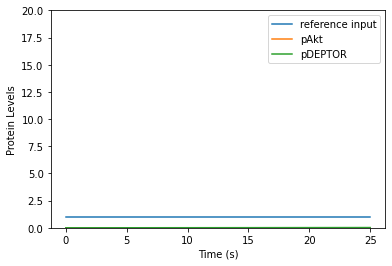

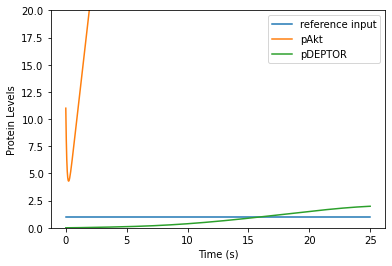

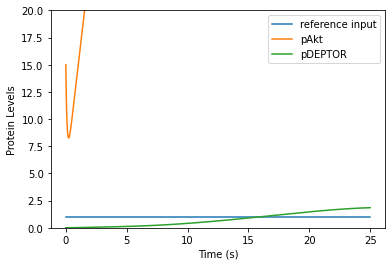

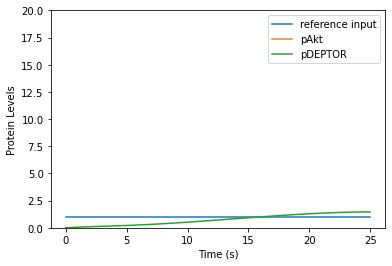

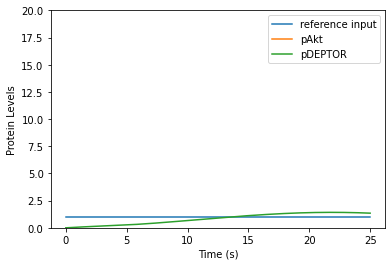

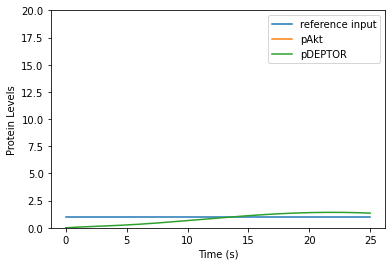

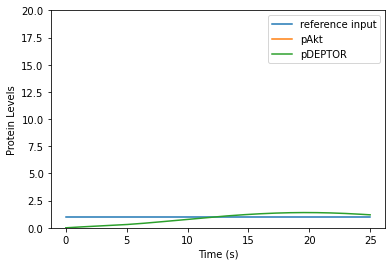

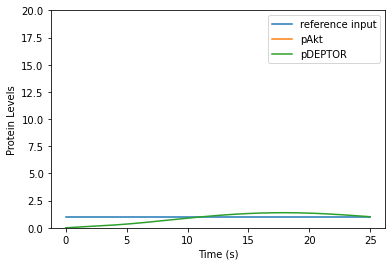

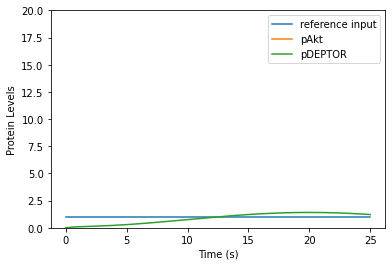

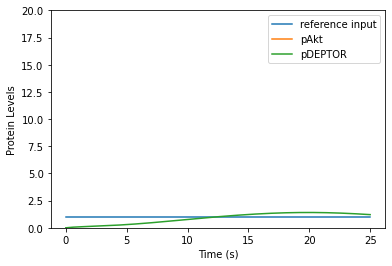

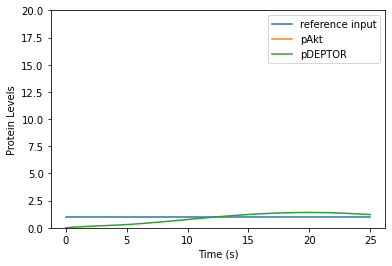

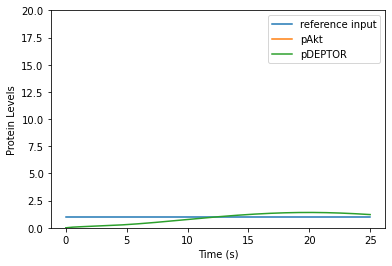

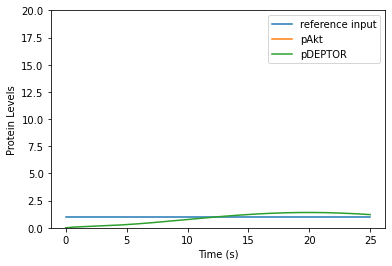

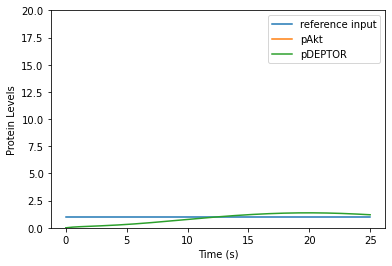

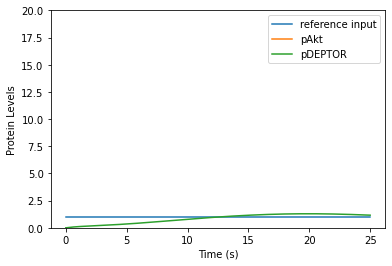

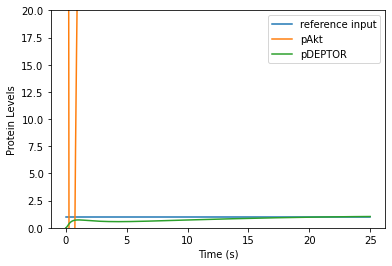

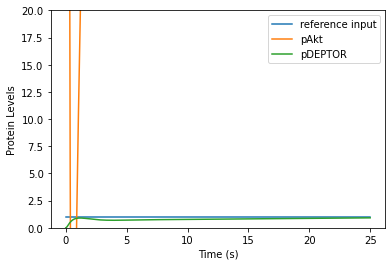

In [ ]:
## Iteration for the ideal kp, ki, and kd values for the PID controller using the evaluateDesign function defined above

""" PLEASE TAKE NOTE: Due to the large values of pAkt, in most cases to get a good view of the system dynamics (reference input in comparison to pDEPTOR)
 pAkt is not able to be visualized on the plot. pAkt is still being plotted but in most cases the y-axis isn't large enough to view it.
 To view the complete dynamics of pAkt please see the last question (Q4) """

result1 = evaluateDesign(0,0,0)
result2 = evaluateDesign(1,1,1)
result = evaluateDesign(5,1,1)
result3 = evaluateDesign(20,1,1)
result4 = evaluateDesign(20,1.2,1)
result5 = evaluateDesign(20,1.2,2)
result6 = evaluateDesign(20,1.35,2)
result7 = evaluateDesign(20,1.5,2)
result8 = evaluateDesign(20,1.35,8)
result9 = evaluateDesign(20,1.35,6)
result10 = evaluateDesign(20,1.35,7)
result11 = evaluateDesign(20,1.35,6.9)
result12 = evaluateDesign(20,1.35,6.5)
result13 = evaluateDesign(22,1.35,6.9)
result14 = evaluateDesign(27.6,1.35,6)
result15 = evaluateDesign(100,1.35,100)
result16 = evaluateDesign(200,1,80)

Difference between output and setpoint at t=10s: 0.1702945867424026


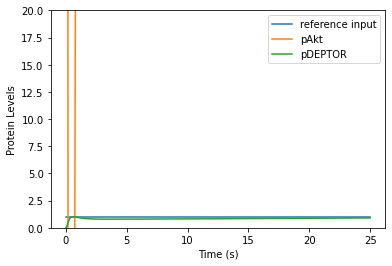

In [ ]:
## Final chosen kp, ki, and kd values
final_result = evaluateDesign(300,1,200)

# Q3. Analyze

In [ ]:
# The step response begins at Time = 1
operating_time = 1

## Obtaining the Transfer Functions for the mTOR System
# from above: kp = 300, ki = 1.35, kd = 200
kp = 300
ki = 1.35
kd = 200
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml", input_names=['pAkt'], output_names=['pDEPTOR'])
Gs = ctlsb.makeTransferFunction(time=operating_time)  # system transfer function
print('Transfer function for mTOR (Gs):', Gs)
Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0]) + control.TransferFunction([kd, 0], [1]) # controller transfer function

HRY = (Gs*Cs)/(1+Gs*Cs)  # Transfer function between input and output
print('HRY Transfer Function:', HRY)
print('HRY Transfer function has a DC gain of 1 when s is factored out')


Transfer function for mTOR (Gs): 
-8.882e-15 s^14 + 0.02894 s^13 + 0.1436 s^12 + 0.1232 s^11 + 0.03313 s^10 + 0.001997 s^9 + 4.396e-05 s^8 + 3.261e-07 s^7 + 5.58e-21 s^6 - 3.883e-39 s^5 - 3.263e-55 s^4 + 1.092e-71 s^3
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   s^15 + 11.54 s^14 + 40.31 s^13 + 46.15 s^12 + 22.19 s^11 + 4.38 s^10 + 0.2466 s^9 + 0.005283 s^8 + 3.864e-05 s^7 + 3.019e-21 s^6 - 2.706e-37 s^5 - 1.487e-55 s^4 - 6.808e-72 s^3

HRY Transfer Function: 
-1.776e-12 s^32 + 5.787 s^31 + 104.2 s^30 + 732.5 s^29 + 2600 s^28 + 5101 s^27 + 5869 s^26 + 4120 s^25 + 1789 s^24 + 472.6 s^23 + 72.39 s^22 + 6.044 s^21 + 0.2915 s^20 + 0.008485 s^19 + 0.0001502 s^18 + 1.555e-06 s^17 + 8.399e-09 s^16 + 1.701e-11 s^15 + 2.924e-25 s^14 + 2.242e-41 s^13 - 2.071e-57 s^12 - 4.644e-76 s^11 + 1.132e-91 s^10 - 3.887e-108 s^9 + 8.075e-127 s^8 - 1.003e-142 s^7
-----

**Answers to Questions**


1. Why are large control inputs required to control the mTOR system?

Large inputs are necessary, because high concentrations of pAkt are necessary to drive the reaction in the direction of making pDEPTOR. In other words, large concentration gradients are necessary to perturb the system. Therefore, this reaction network on its own is very stable and insensitive to small changes in pAkt concentrations. 

2. Why are there no long term oscillations in the closed loop system?

We did not introduce any noise or disturbances so we are viewing an ideal system. Adding these disturbances into the closed system will cause deviations between the output and the setpoint giving the long term oscillations around the reference input/setpoint. 

3. How will a step increase in noise affect the output of the closed loop


Very similar to the previous response, any noise will cause oscillations in your system especially if there is no filter in place. It also may take longer to approach the reference input. This is because adding a filter will increase bias in your system.





# Q4. Discussion

Text(0, 0.5, 'Protein Levels')

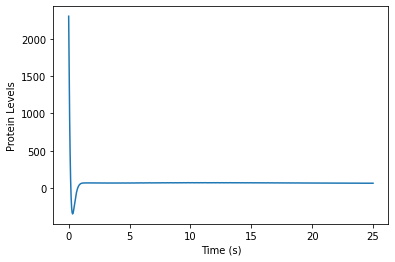

In [ ]:
pAkt_values = final_result.outputs[1]  # extracts the values of pAkt from the closed loop system
plt.plot(final_result.t, pAkt_values.flatten())
plt.xlabel('Time (s)')
plt.ylabel('Protein Levels')

What issues do you see with using this closed loop system in practice?

The first issue I see is that we are viewing an idealized system that is free of stochastic and intrinsic noise present in biological systems. Although, it may take less than 10 seconds to equilibriate, this would not be the case in practice. 

Another issue is that the cell must tolerate a drastic increase in pAkt. As mentioned earlier, due to the tight control in this pathway, it is necessary to supply a large concentration of pAkt to see any small changes in the concentration of pDEPTOR. As you can see from the above graph, over time the pAkt levels return to the basal level of around 70. However, to force an increase in pDEPTOR the pAkt levels must first be increased to around 500. That is over a 700% increase in cellular pAkt levels which may affect the fitness in your cellular population. This would certainly be a problem initiating in vivo.

A very blatant issue looking at the graph above, is that there are negative protein levels of pAkt. As this is clearly impossible, we would need to change our current control parameters. We can circumvent this issue by using the result16 from above which has kp=100, ki=1.35, and kd = 80. 

Lastly, to be able to control this pathway, we would need a cellular device capable of sensing and controlling pDEPTOR levels in response to pAkt levels. Building feedback controllers is still a very active area of synthetic biology research so building this controller would be a monumental task.